In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from information_estimation import *
from image_utils import *
from gaussian_process_utils import *
from plot_utils import *

from led_array.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

Opening BSCCM
Opened BSCCM


## Very similar answer if you've got the eigenvalue floor set correctly


building toeplitz mat: 100%|██████████| 19/19 [00:00<00:00, 36.61it/s]


Estimated H(Y|X) = 6.299 bits/pixel
Estimated H(Y) = 6.546 bits/pixel
Estimated I(Y;X) = 0.247 bits/pixel
Initial loss:  454.47285228174115
Iteration 100, validation loss: 454.2833125780245
Final loss:  454.28309629670883
Estimated H(Y|X) = 6.299 bits/pixel
Estimated H(Y) = 6.559 bits/pixel
Estimated I(Y;X) = 0.259 bits/pixel
Regular MI: 0.247
Optimized MI: 0.259

bad EV floor
Estimated H(Y|X) = 6.299 bits/pixel
Estimated H(Y) = 6.091 bits/pixel
Estimated I(Y;X) = -0.209 bits/pixel


/home/hpinkard_waller/GitRepos/EncodingInformation/gaussian_process_utils.py:40: UserWarning: Cannot make both doubly toeplitz and positive definite. Using positive definite matrix.Smallest eigenvalue is -28.669808364199497
  warnings.warn('Cannot make both doubly toeplitz and positive definite. Using positive definite matrix.'


Initial loss:  289805.3353424459
Iteration 31, validation loss: 455.31939583608846
Final loss:  454.3870305261745
Estimated H(Y|X) = 6.299 bits/pixel
Estimated H(Y) = 6.533 bits/pixel
Estimated I(Y;X) = 0.234 bits/pixel
Regular MI: -0.209
Optimized MI: 0.234


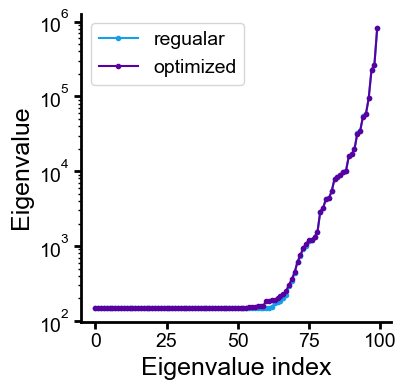

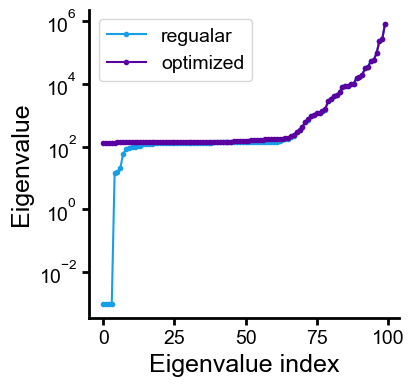

In [2]:
# load images, extract patches, and compute cov mats
edge_crop = 32
patch_size = 10
num_images = 10000
num_patches = 10000
channel = 'LED119'

images = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=edge_crop, median_filter=False)
seed = 10 # this seed gives a really bad inital fit
# seed = 1
patches = extract_patches(images, patch_size, num_patches=num_images, seed=seed, verbose=True)

eigenvalue_floor = 1.5e2

mi_regular, cov_mat_regular = estimate_mutual_information(patches, use_iterative_optimization=False, verbose=True, return_cov_mat=True, eigenvalue_floor=eigenvalue_floor)
mi_optimized, cov_mat_optmized = estimate_mutual_information(patches, use_iterative_optimization=True, verbose=True, return_cov_mat=True, eigenvalue_floor=eigenvalue_floor)

print(f"Regular MI: {mi_regular:.3f}")
print(f"Optimized MI: {mi_optimized:.3f}")
plot_eigenvalues(regualar=cov_mat_regular, optimized=cov_mat_optmized)


print ('\nbad EV floor')
eigenvalue_floor = 1e-3

mi_regular, cov_mat_regular = estimate_mutual_information(patches, use_iterative_optimization=False, verbose=True, return_cov_mat=True, eigenvalue_floor=eigenvalue_floor)
mi_optimized, cov_mat_optmized = estimate_mutual_information(patches, use_iterative_optimization=True, verbose=True, return_cov_mat=True, eigenvalue_floor=eigenvalue_floor)

print(f"Regular MI: {mi_regular:.3f}")
print(f"Optimized MI: {mi_optimized:.3f}")
plot_eigenvalues(regualar=cov_mat_regular, optimized=cov_mat_optmized)

## But it only takes a few iterations to get it right

Initial loss:  289805.3353424459
Iteration 16, validation loss: 455.1833778257231
Final loss:  454.3716607819195


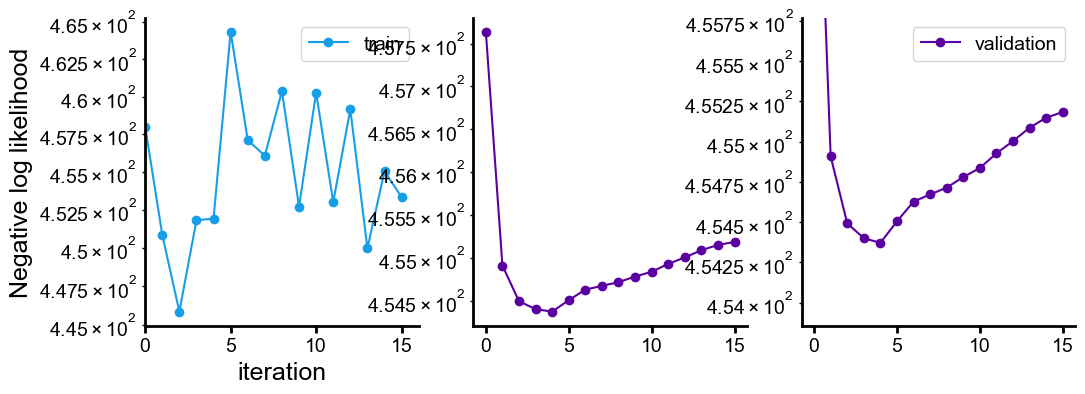

In [3]:
cov_mat_optimized, cov_mat_initial, mean_vec, best_loss, train_loss_history, val_loss_history, final_cov_mat = fit_optimized_gaussian(
    patches, num_validation=100, max_iters=50, patience=10, return_everything=True, verbose=True)

plot_optimization_loss_history(train_loss_history, val_loss_history)